In [1]:
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import ReconstructionLoss, TemporalLoss, SingleVisLoss, DummyTemporalLoss
from singleVis.backend import convert_distance_to_probability, compute_cross_entropy
from singleVis.edge_dataset import VisDataHandler
from singleVis.trainer import BaseTextTrainer
from singleVis.eval.evaluator import Evaluator
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import SingleEpochTextSpatialEdgeConstructor

from singleVis.projector import VISProjector
from singleVis.utils import find_neighbor_preserving_rate

/home/yiming/anaconda3/envs/visualizer/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch import nn
class UmapLoss(nn.Module):
    def __init__(self, negative_sample_rate, device, _a=1.0, _b=1.0, repulsion_strength=1.0):
        super(UmapLoss, self).__init__()

        self._negative_sample_rate = negative_sample_rate
        self._a = _a,
        self._b = _b,
        self._repulsion_strength = repulsion_strength
        self.DEVICE = torch.device(device)

    @property
    def a(self):
        return self._a[0]

    @property
    def b(self):
        return self._b[0]

    def forward(self, embedding_to, embedding_from, probs):
        # get negative samples
        batch_size = embedding_to.shape[0]
        embedding_neg_to = torch.repeat_interleave(embedding_to, self._negative_sample_rate, dim=0)
        repeat_neg = torch.repeat_interleave(embedding_from, self._negative_sample_rate, dim=0)
        randperm = torch.randperm(repeat_neg.shape[0])
        embedding_neg_from = repeat_neg[randperm]
        neg_num = len(embedding_neg_from)

        positive_distance = torch.norm(embedding_to - embedding_from, dim=1)
        negative_distance = torch.norm(embedding_neg_to - embedding_neg_from, dim=1)

        distance_embedding = torch.cat(
            (
                positive_distance,
                negative_distance,
            ),
            dim=0,
        )
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, self.a, self.b
        )
        probabilities_distance = probabilities_distance.to(self.DEVICE)

        probabilities_graph = torch.cat(
            (torch.ones(batch_size).to(self.DEVICE), torch.zeros(neg_num).to(self.DEVICE)), dim=0,
        )

        # probabilities_graph = torch.cat(
        #     (probs.to(self.DEVICE), torch.zeros(neg_num).to(self.DEVICE)), dim=0,
        # )

        probabilities_graph = probabilities_graph.to(device=self.DEVICE)

        # compute cross entropy
        (_, _, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=self._repulsion_strength,
        )   

        return torch.mean(ce_loss)

class DVILoss(nn.Module):
    def __init__(self, umap_loss, recon_loss, temporal_loss, lambd1, lambd2, device):
        super(DVILoss, self).__init__()
        self.umap_loss = umap_loss
        self.recon_loss = recon_loss
        self.temporal_loss = temporal_loss
        self.lambd1 = lambd1
        self.lambd2 = lambd2
        self.device = device

    def forward(self, edge_to, edge_from, a_to, a_from, curr_model,probs):
      
        outputs = curr_model( edge_to, edge_from)
        embedding_to, embedding_from = outputs["umap"]
        recon_to, recon_from = outputs["recon"]

        recon_l = self.recon_loss(edge_to, edge_from, recon_to, recon_from, a_to, a_from).to(self.device)
        umap_l = self.umap_loss(embedding_to, embedding_from, probs)
        temporal_l = self.temporal_loss(curr_model).to(self.device)

        loss = umap_l + self.lambd1 * recon_l + self.lambd2 * temporal_l

        return umap_l, umap_l, self.lambd1 *recon_l, self.lambd2 *temporal_l, loss

In [3]:
import re
import numpy as np

def remove_docstrings(code):
    # 使用正则表达式匹配被 """ 包括的部分，并替换为空字符串
    cleaned_code = re.sub(r'""".*?"""', '', code, flags=re.DOTALL)
    cleaned_code = re.sub(r"'''.*?'''", '', cleaned_code, flags=re.DOTALL)
    return cleaned_code

def cosine_similarity_matrix(nl_features, code_features):
    # 计算每个特征向量的范数
    nl_norms = np.linalg.norm(nl_features, axis=1, keepdims=True)
    code_norms = np.linalg.norm(code_features, axis=1, keepdims=True)
    
    # 计算点积
    dot_product = np.dot(nl_features, code_features.T)
    
    # 计算余弦相似度矩阵
    cosine_similarity = dot_product / (nl_norms * code_norms.T)
    
    return cosine_similarity

In [4]:
def remove_padding_intervals(tokenized_id_data):
    """
    移除 tokenized_id_data 中所有 `[0,0]` 区间（除非它是开头的第一个区间）。

    Args:
    - tokenized_id_data (list of lists): 包含区间的列表，每个区间是一个长度为 2 的列表。

    Returns:
    - filtered_data (list of lists): 移除 `[0,0]` 填充数据后的区间列表。
    """
    if isinstance(tokenized_id_data, np.ndarray):
        tokenized_id_data = tokenized_id_data.tolist()  # 将 NumPy 数组转换为列表
    # 处理的结果列表
    filtered_data = []

    # 保留开头的 `[0,0]` 区间（如果存在）
    if tokenized_id_data and tokenized_id_data[0] == [0,0]:
        filtered_data.append([0,0])
        start_index = 1  # 从第二个元素开始检查
    else:
        start_index = 0

    # 处理剩余的区间
    for interval in tokenized_id_data[start_index:]:
        if interval != [0,0]:  # 仅添加非 `[0,0]` 区间
            filtered_data.append(interval)

    return filtered_data

In [5]:
import json
def load_loss_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return np.array(data)

In [6]:
with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/dataset/python/train.jsonl", "r") as f:
    train_dataset = [json.loads(line) for line in f.readlines()]


In [7]:
import json
input_path = "/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/sorted_labelling_sample_api_student_conf_sorted.jsonl"
idx_list = []
match_list = []

with open(input_path, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip().rstrip(',')  # 去除行末的逗号
        json_obj = json.loads(line)
        idx_list.append(json_obj['idx'])
        match_list.append(json_obj['match'])

In [8]:
import json
import os

# 文件路径
json_file_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/tokenized_code_tokens_train.json'

# 读取JSON文件
with open(json_file_path, 'r', encoding='utf-8') as f:
    code_tokens_data = json.load(f)

# 文件路径
json_file_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/tokenized_comment_tokens_train.json'


# 读取JSON文件
with open(json_file_path, 'r', encoding='utf-8') as f:
    nl_tokens_data = json.load(f)

In [96]:
data_ind = 0
convert_idx = 92
convert_idx_code = 92

In [97]:
import numpy as np

# 文件路径
nl_tokens_paths = [f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/train_nl_tokens.npy' for i in range(1,51)]
code_tokens_paths = [f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/train_code_tokens.npy' for i in range(1,51)]

# 读取nl_tokens.npy
all_nl_tokens_list = []
for path in nl_tokens_paths:
    all_nl_tokens_list.append(np.load(path))

# 读取code_tokens.npy 
all_code_tokens_list = []
for path in code_tokens_paths:
    all_code_tokens_list.append(np.load(path))

In [98]:
# 文件路径
code_attention_paths = [f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/train_code_attention.npy' for i in range(1,51)]
nl_attention_paths = [f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/train_nl_attention.npy' for i in range(1,51)]

# 读取code attention features
code_attention_features = []
for path in code_attention_paths:
    code_attention_features.append(np.load(path))

# 读取nl attention features
nl_attention_features = []
for path in nl_attention_paths:
    nl_attention_features.append(np.load(path))

In [99]:
code_data = code_tokens_data[convert_idx_code]
comment_data = nl_tokens_data[convert_idx]

In [100]:
output_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/code_labels/'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 遍历列表的每一项
for i, token_list in enumerate(code_data):
   
    # 生成输出文件路径
    output_file_path = os.path.join(output_dir, f'text_{i}.txt')
    
    # 保存到文件中，去除G点符号并加上序号
    with open(output_file_path, 'w', encoding='utf-8') as f_out:
        token_str = str(code_data[i]).replace('Ġ', '')
        f_out.write(f"{i}: {token_str}")
    # 找到</s>的位置，并保留其之前的部分
    if '</s>' == token_list:
        code_length = i
        break

print("处理完成！")

处理完成！


In [101]:
output_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/comment_labels/'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 遍历列表的每一项
for i, token_list in enumerate(comment_data):
   
    # 生成输出文件路径
    output_file_path = os.path.join(output_dir, f'text_{i}.txt')
    
    # 保存到文件中，去除G点符号并加上序号
    with open(output_file_path, 'w', encoding='utf-8') as f_out:
        token_str = str(comment_data[i]).replace('Ġ', '')
        f_out.write(f"{i}: {token_str}")
    # 找到</s>的位置，并保留其之前的部分
    if '</s>' == token_list:
        comment_length = i
        break

print("处理完成！")

处理完成！


In [102]:
comment_length

10

In [103]:
output_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/'
code_text = '<s> ' + train_dataset[convert_idx_code]['code']
comment_text = '<s> ' + train_dataset[convert_idx]['docstring']
# Create dictionary with the required data
data_dict = {
    'code_text': code_text,  # Original code text from training dataset
    'comment_text': comment_text,  # Original docstring text from training dataset
    'code_tokens': code_data[:code_length],  # Code tokens after truncation
    'comment_tokens': comment_data[:comment_length]  # Comment tokens after truncation
}

# Save to full_text.json
output_path = os.path.join(output_dir, 'full_text.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(data_dict, f, ensure_ascii=False, indent=2)

In [104]:
# 获取 n 和 m
n = comment_length
m = code_length

# 对每个epoch分别处理
for epoch in range(1, 51):
    # 读取当前epoch的nl_tokens和code_tokens
    nl_tokens = all_nl_tokens_list[epoch-1][data_ind][:n]
    code_tokens = all_code_tokens_list[epoch-1][data_ind][:m]
    
    # nl_tokens[0] = nl_cls_tokens[comment_id]
    # code_tokens[0] = code_cls_tokens[data_ind]
    
    # 拼接两部分数据
    combined_data = np.concatenate((nl_tokens, code_tokens))
    print(f"Epoch {epoch} data shape:", combined_data.shape)
    
    # 检查并创建保存目录
    output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_{epoch}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 保存到对应epoch的目录
    output_path = os.path.join(output_dir, 'train_data.npy')
    np.save(output_path, combined_data)
    # print(f"Epoch {epoch} 数据已保存到 {output_path}")


Epoch 1 data shape: (69, 768)
Epoch 2 data shape: (69, 768)
Epoch 3 data shape: (69, 768)
Epoch 4 data shape: (69, 768)
Epoch 5 data shape: (69, 768)
Epoch 6 data shape: (69, 768)
Epoch 7 data shape: (69, 768)
Epoch 8 data shape: (69, 768)
Epoch 9 data shape: (69, 768)
Epoch 10 data shape: (69, 768)
Epoch 11 data shape: (69, 768)
Epoch 12 data shape: (69, 768)
Epoch 13 data shape: (69, 768)
Epoch 14 data shape: (69, 768)
Epoch 15 data shape: (69, 768)
Epoch 16 data shape: (69, 768)
Epoch 17 data shape: (69, 768)
Epoch 18 data shape: (69, 768)
Epoch 19 data shape: (69, 768)
Epoch 20 data shape: (69, 768)
Epoch 21 data shape: (69, 768)
Epoch 22 data shape: (69, 768)
Epoch 23 data shape: (69, 768)
Epoch 24 data shape: (69, 768)
Epoch 25 data shape: (69, 768)
Epoch 26 data shape: (69, 768)
Epoch 27 data shape: (69, 768)
Epoch 28 data shape: (69, 768)
Epoch 29 data shape: (69, 768)
Epoch 30 data shape: (69, 768)
Epoch 31 data shape: (69, 768)
Epoch 32 data shape: (69, 768)
Epoch 33 data sha

In [105]:
import json

# 生成从0到m-1的索引
indices = list(range(m))

# 为每个epoch创建并保存索引
for epoch in range(1, 51):
    # 生成当前epoch的输出路径
    output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_{epoch}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    index_output_path = os.path.join(output_dir, 'code_index.json')
    
    # 将索引保存到index.json中
    with open(index_output_path, 'w', encoding='utf-8') as f_out:
        json.dump(indices, f_out, ensure_ascii=False, indent=4)
        
    # print(f"索引已保存到 {index_output_path}")


In [106]:
# 生成从0到n-1的索引
indices = list(range(n))

# 为每个epoch创建并保存索引
for epoch in range(1, 51):
    # 生成当前epoch的输出路径
    output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_{epoch}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data_index_output_path = os.path.join(output_dir, 'comment_index.json')
    
    # 将索引保存到data_index.json中
    with open(data_index_output_path, 'w', encoding='utf-8') as f_out:
        json.dump(indices, f_out, ensure_ascii=False, indent=4)
        
    # print(f"索引已保存到 {data_index_output_path}")

In [107]:
# 生成从0到n+m-1的索引
indices = list(range(len(combined_data)))

# 为每个epoch创建并保存索引
for epoch in range(1, 51):
    # 生成当前epoch的输出路径
    output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_{epoch}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    index_output_path = os.path.join(output_dir, 'index.json')
    
    # 将索引保存到index.json中
    with open(index_output_path, 'w', encoding='utf-8') as f_out:
        json.dump(indices, f_out, ensure_ascii=False, indent=4)
        
    # print(f"索引已保存到 {index_output_path}")

In [108]:
import numpy as np
import json
import os
from sklearn.metrics.pairwise import cosine_similarity

# 初始化存储所有epoch数据的列表
all_intra_comment_sims = []
all_intra_code_sims = []
all_inter_comment_code_sims = []
all_inter_code_comment_sims = []

# 对每个epoch进行处理
for epoch in range(1, 51):
    # 读取数据
    data_path = f'/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_{epoch}/train_data.npy'
    data = np.load(data_path)

    # 读取 comment token 长度
    data_index_path = f'/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_{epoch}/comment_index.json'
    with open(data_index_path, 'r') as f:
        comment_length = len(json.load(f))

    # 将数据分为前半部分的comment和后半部分的code
    comments = data[:comment_length]  # 前半部分是comment
    code_tokens = data[comment_length:]  # 后半部分是code

    # 计算相似度函数（使用余弦相似度）
    def compute_similarity(tokens_a, tokens_b):
        return cosine_similarity(tokens_a, tokens_b)

    # intra 相似度计算
    intra_comment_sim = compute_similarity(comments, comments)
    intra_code_sim = compute_similarity(code_tokens, code_tokens)

    # inter 相似度计算
    inter_comment_code_sim = compute_similarity(comments, code_tokens)
    inter_code_comment_sim = compute_similarity(code_tokens, comments)

    # 获取前 k 个最近邻
    k = 10  # 假设我们需要前 5 个最近邻

    # intra 计算
    def get_intra_neighbors(sim_matrix, k, offset=0):
        neighbors = []
        for i in range(len(sim_matrix)):
            # 获取当前样本对其他样本的相似度排序
            sorted_indices = np.argsort(-sim_matrix[i])
            # 如果样本数量不足k个，用自身的索引补齐
            if len(sorted_indices) < k:
                needed = k - len(sorted_indices)
                neighbors.append(np.concatenate([
                    sorted_indices + offset,
                    np.array([i + offset] * needed)
                ]))
            else:
                neighbors.append(sorted_indices[:k] + offset)
        return np.array(neighbors)

    intra_comment_neighbors = get_intra_neighbors(intra_comment_sim, k)
    intra_code_neighbors = get_intra_neighbors(intra_code_sim, k, comment_length)

    # inter 计算 - 应该使用专门的函数处理comment到code的映射
    def get_comment_to_code_neighbors(sim_matrix, k, code_offset):
        neighbors = []
        for i in range(len(sim_matrix)):
            # 获取当前注释对所有代码的相似度排序
            sorted_indices = np.argsort(-sim_matrix[i])
            # 将代码的索引加上offset以对应实际位置
            neighbors.append(sorted_indices[:k] + code_offset)
        return np.array(neighbors)

    inter_comment_neighbors = get_comment_to_code_neighbors(inter_comment_code_sim, k, comment_length)  # comment 对 code 的相似度
    
    def get_code_to_comment_neighbors(sim_matrix, k, comment_length):
        neighbors = []
        for i in range(len(sim_matrix)):
            # 获取当前代码对所有注释的相似度排序
            sorted_indices = np.argsort(-sim_matrix[i])
            # 如果注释数量不足k个，用代码自身的索引补齐
            if len(sorted_indices) < k:
                needed = k - len(sorted_indices)
                neighbors.append(np.concatenate([
                    sorted_indices,
                    np.array([i + comment_length] * needed)
                ]))
            else:
                neighbors.append(sorted_indices[:k])
        return np.array(neighbors)

    inter_code_neighbors = get_code_to_comment_neighbors(inter_code_comment_sim, k, comment_length)

    # 拼接 intra 和 inter 结果
    intra_neighbors = np.concatenate([intra_comment_neighbors, intra_code_neighbors], axis=0)
    inter_neighbors = np.concatenate([inter_comment_neighbors, inter_code_neighbors], axis=0)

    # 将当前epoch的结果添加到列表中
    all_intra_comment_sims.append(intra_comment_sim)
    all_intra_code_sims.append(intra_code_sim)
    all_inter_comment_code_sims.append(inter_comment_code_sim)
    all_inter_code_comment_sims.append(inter_code_comment_sim)

    # 保存每个epoch的邻居信息
    save_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model'

    # 为当前epoch创建保存路径
    epoch_dir = os.path.join(save_dir, f'Epoch_{epoch}')
    os.makedirs(epoch_dir, exist_ok=True)

    # 保存邻居信息
    np.save(os.path.join(epoch_dir, 'intra_similarity.npy'), intra_neighbors)
    np.save(os.path.join(epoch_dir, 'inter_similarity.npy'), inter_neighbors)



In [109]:
# 预设10种高对比度颜色
high_contrast_colors = [
    "#FF0000", "#00FF00", "#0000FF", "#FFA500", "#FF00FF", 
    "#00FFFF", "#800000", "#008000", "#000080", "#808000"
]

In [110]:
# 判断convert_idx和convert_idx_code是否相同
if convert_idx == convert_idx_code:
    indices = [i for i, value in enumerate(idx_list) if value == convert_idx]

    # 提取match_list中对应索引的值
    match_values = [match_list[i] for i in indices]

    # 输出结果
    print("Indices of 7045 in idx_list:", indices)
    print("Corresponding values in match_list:", match_values)
    # 初始化结果列表
    comment_list = []
    code_list = []

    # 遍历 match_values，处理每个 comment 和 code 的区间
    for match in match_values[0]:  # 假设 match_values 的结构是 [[...]]
        comment_intervals, code_intervals = match

        # 展开 comment 的所有索引
        data_indices = []
        for start, end in zip(comment_intervals[::2], comment_intervals[1::2]):
            data_indices.extend(range(start, end + 1))
        comment_list.append(data_indices)

        # 展开 code 的所有索引
        data_indices = []
        for start, end in zip(code_intervals[::2], code_intervals[1::2]):
            data_indices.extend(range(start, end + 1))
        code_list.append(data_indices)

else:
    # 分别提取comment和code的indices
    comment_indices = [i for i, value in enumerate(idx_list) if value == convert_idx]
    code_indices = [i for i, value in enumerate(idx_list) if value == convert_idx_code]

    # 提取对应的match values
    comment_match_values = [match_list[i] for i in comment_indices]
    code_match_values = [match_list[i] for i in code_indices]

    # 初始化结果列表
    comment_list = []
    code_list = []

    # 处理comment的区间
    if comment_match_values:
        for match in comment_match_values[0]:
            comment_intervals, _ = match
            comment_range = []
            for start, end in zip(comment_intervals[::2], comment_intervals[1::2]):
                comment_range.extend(range(start, end + 1))
            comment_list.append(comment_range)

    # 处理code的区间
    if code_match_values:
        for match in code_match_values[0]:
            _, code_intervals = match
            code_range = []
            for start, end in zip(code_intervals[::2], code_intervals[1::2]):
                code_range.extend(range(start, end + 1))
            code_list.append(code_range)

# 输出结果
print("Comment indices list:", comment_list)
print("Code indices list:", code_list)


Indices of 7045 in idx_list: [3]
Corresponding values in match_list: [[[[0, 0], [1, 1, 32, 35]], [[1, 1, 4, 4, 7, 7], [27, 28, 37, 38, 53, 54]], [[6, 6], [8, 8, 10, 10, 17, 18, 21, 21, 29, 30, 42, 46, 48, 51]]]]
Comment indices list: [[0], [1, 4, 7], [6]]
Code indices list: [[1, 32, 33, 34, 35], [27, 28, 37, 38, 53, 54], [8, 10, 17, 18, 21, 29, 30, 42, 43, 44, 45, 46, 48, 49, 50, 51]]


In [111]:
import numpy as np
from collections import deque
from IPython.display import display, HTML, clear_output
import time

# 处理code部分
code_snippet = remove_docstrings(train_dataset[convert_idx_code]["code"])
token_list2 = code_tokens_data[convert_idx_code][1:]
token_list1 = nl_tokens_data[convert_idx][1:]
# Get docstring and remove parameter descriptions
doc_snippet = train_dataset[convert_idx]["docstring"].split("\n")[0]

# 对1-50 epoch分别计算
for epoch in range(1, 51):
    # 清除上一次的输出
    clear_output(wait=True)
    
    # 处理comment部分
    array = nl_attention_features[epoch-1][data_ind]  # 从list中获取对应epoch的数据
    array = array[1:]
    
    normalized_contributions = (array - array.min()) / (array.max() - array.min())
    tokens_with_contributions = deque([(token.replace("Ġ", ""), contrib) for token, contrib in zip(token_list1, normalized_contributions)])

    code_attention_feature = code_attention_features[epoch-1][data_ind][1:]
    code_normalized_contributions = (code_attention_feature - code_attention_feature.min()) / (code_attention_feature.max() - code_attention_feature.min())
    code_tokens_with_contributions = deque([(token.replace("Ġ", ""), contrib) for token, contrib in zip(token_list2, code_normalized_contributions)])

    # 为每个索引组指定颜色
    color_map_comment = {}
    color_map_code = {}
    for i, indices in enumerate(comment_list):
        color = high_contrast_colors[i % len(high_contrast_colors)]
        for idx in indices:
            color_map_comment[idx] = color
    for i, indices in enumerate(code_list):
        color = high_contrast_colors[i % len(high_contrast_colors)]
        for idx in indices:
            color_map_code[idx] = color
            
    # 生成HTML输出
    html_string = f"<h3 style='margin:0'>Epoch {epoch}</h3>"
    
    # Comment部分
    html_string += "<h4 style='margin:0'>Comment:</h4><pre>"
    buffer = ""
    current_index = 0
    for char in doc_snippet:
        if char == "\n":
            html_string += buffer + "<br>"
            buffer = ""
        elif tokens_with_contributions:
            token, contrib = tokens_with_contributions[0]
            buffer += char
            if buffer == token:
                font_size = 8 + (16 - 8) * contrib
                color = color_map_comment.get(current_index, "black")
                html_string += f'<span style="font-size: {font_size}px; color: {color};">{buffer}</span>'
                buffer = ""
                tokens_with_contributions.popleft()
                current_index += 1
            elif not token.startswith(buffer):
                color = color_map_comment.get(current_index, "black")
                html_string += f'<span style="color: {color};">{buffer[0]}</span>'
                buffer = buffer[1:]
        else:
            color = color_map_comment.get(current_index, "black")
            html_string += f'<span style="color: {color};">{char}</span>'
    html_string += buffer + "</pre>"

    # Code部分
    html_string += "<h4 style='margin:0'>Code:</h4><pre>"
    buffer = ""
    current_index = 0
    for char in code_snippet:
        if char == "\n":
            html_string += buffer + "<br>"
            buffer = ""
        elif code_tokens_with_contributions:
            token, contrib = code_tokens_with_contributions[0]
            buffer += char
            if buffer == token:
                font_size = 8 + (16 - 8) * contrib
                color = color_map_code.get(current_index, "black")
                html_string += f'<span style="font-size: {font_size}px; color: {color};">{buffer}</span>'
                buffer = ""
                code_tokens_with_contributions.popleft()
                current_index += 1
            elif not token.startswith(buffer):
                color = color_map_code.get(current_index, "black")
                html_string += f'<span style="color: {color};">{buffer[0]}</span>'
                buffer = buffer[1:]
        else:
            color = color_map_code.get(current_index, "black")
            html_string += f'<span style="color: {color};">{char}</span>'
    html_string += buffer + "</pre>"

    # 显示结果
    display(HTML(html_string))
    
    # 添加延迟以便观察动画效果
    time.sleep(0.8)

In [112]:
train_dataset[19591]["code_tokens"][7]

'message'

In [113]:
train_dataset[19591]["docstring_tokens"][0]

'Log'

In [114]:
# import matplotlib.pyplot as plt
# # Calculate sum of attention by color groups
# color_groups_comment = {}
# color_groups_code = {}

# # Group attentions by color for comments
# for idx, color in color_map_comment.items():
#     if color not in color_groups_comment:
#         color_groups_comment[color] = []
#     color_groups_comment[color].append(array[idx])

# # Group attentions by color for code
# for idx, color in color_map_code.items():
#     if color not in color_groups_code:
#         color_groups_code[color] = []
#     color_groups_code[color].append(code_attention_feature[idx])

# # Calculate sums for each color group
# comment_color_sums = {color: np.sum(attns) for color, attns in color_groups_comment.items()}
# code_color_sums = {color: np.sum(attns) for color, attns in color_groups_code.items()}

# # Print comparison with color blocks
# print("Attention sums by color group:")
# print("\nComment:")
# for color, sum_val in comment_color_sums.items():
#     print(f"\033[48;2;{int(color[1:3],16)};{int(color[3:5],16)};{int(color[5:7],16)}m  \033[0m {color}: {sum_val:.4f}")
    
# print("\nCode:")
# for color, sum_val in code_color_sums.items():
#     print(f"\033[48;2;{int(color[1:3],16)};{int(color[3:5],16)};{int(color[5:7],16)}m  \033[0m {color}: {sum_val:.4f}")

# # Plot comparison
# plt.figure(figsize=(12,6))

# colors = list(set(color_map_comment.values()) | set(color_map_code.values()))
# x = np.arange(len(colors))
# width = 0.35

# comment_sums = [comment_color_sums.get(c, 0) for c in colors]
# code_sums = [code_color_sums.get(c, 0) for c in colors]

# plt.bar(x - width/2, comment_sums, width, label='Comment', color='blue')
# plt.bar(x + width/2, code_sums, width, label='Code', color='orange')

# plt.xlabel('Color Groups')
# plt.ylabel('Sum of Attention')
# plt.title('Comparison of Attention Sums by Color Group')

# # Create colored rectangles for x-axis labels
# ax = plt.gca()
# ax.set_xticks(x)
# ax.set_xticklabels([''] * len(colors))  # Clear text labels
# for i, color in enumerate(colors):
#     ax.add_patch(plt.Rectangle((i-0.2, -0.1), 0.4, 0.05, color=color, transform=ax.transData))

# plt.legend()
# plt.show()


Attention sums by color group:

Comment:
   #FF0000: 0.3273
   #00FF00: 0.0746
   #0000FF: 0.0642

Code:
   #FF0000: 0.3504
   #00FF00: 0.0303
   #0000FF: 0.1376


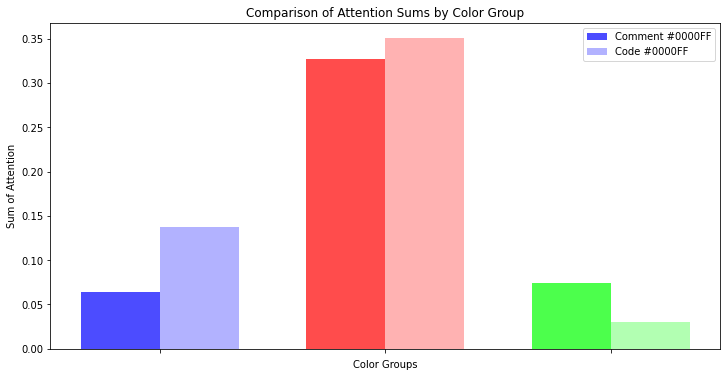

In [115]:
import matplotlib.pyplot as plt
# Calculate sum of attention by color groups
color_groups_comment = {}
color_groups_code = {}

# Group attentions by color for comments
for idx, color in color_map_comment.items():
    if color not in color_groups_comment:
        color_groups_comment[color] = []
    color_groups_comment[color].append(array[idx])

# Group attentions by color for code
for idx, color in color_map_code.items():
    if color not in color_groups_code:
        color_groups_code[color] = []
    color_groups_code[color].append(code_attention_feature[idx])

# Calculate sums for each color group
comment_color_sums = {color: np.sum(attns) for color, attns in color_groups_comment.items()}
code_color_sums = {color: np.sum(attns) for color, attns in color_groups_code.items()}

# Print comparison with color blocks
print("Attention sums by color group:")
print("\nComment:")
for color, sum_val in comment_color_sums.items():
    print(f"\033[48;2;{int(color[1:3],16)};{int(color[3:5],16)};{int(color[5:7],16)}m  \033[0m {color}: {sum_val:.4f}")
    
print("\nCode:")
for color, sum_val in code_color_sums.items():
    print(f"\033[48;2;{int(color[1:3],16)};{int(color[3:5],16)};{int(color[5:7],16)}m  \033[0m {color}: {sum_val:.4f}")

# Plot comparison
plt.figure(figsize=(12,6))

colors = list(set(color_map_comment.values()) | set(color_map_code.values()))
x = np.arange(len(colors))
width = 0.35

comment_sums = [comment_color_sums.get(c, 0) for c in colors]
code_sums = [code_color_sums.get(c, 0) for c in colors]

# Use the same colors for both comment and code bars
for i, (c_sum, cd_sum, color) in enumerate(zip(comment_sums, code_sums, colors)):
    plt.bar(i - width/2, c_sum, width, color=color, alpha=0.7, label=f'Comment {color}' if i==0 else "")
    plt.bar(i + width/2, cd_sum, width, color=color, alpha=0.3, label=f'Code {color}' if i==0 else "")

plt.xlabel('Color Groups')
plt.ylabel('Sum of Attention')
plt.title('Comparison of Attention Sums by Color Group')

# Create colored rectangles for x-axis labels
ax = plt.gca()
ax.set_xticks(x)
ax.set_xticklabels([''] * len(colors))  # Clear text labels
for i, color in enumerate(colors):
    ax.add_patch(plt.Rectangle((i-0.2, -0.1), 0.4, 0.05, color=color, transform=ax.transData))

plt.legend()
plt.show()


In [116]:
print(train_dataset[29433]["code"])

def get_subgraphs_by_annotation(graph, annotation, sentinel=None):
    """Stratify the given graph into sub-graphs based on the values for edges' annotations.

    :param pybel.BELGraph graph: A BEL graph
    :param str annotation: The annotation to group by
    :param Optional[str] sentinel: The value to stick unannotated edges into. If none, does not keep undefined.
    :rtype: dict[str,pybel.BELGraph]
    """
    if sentinel is not None:
        subgraphs = _get_subgraphs_by_annotation_keep_undefined(graph, annotation, sentinel)
    else:
        subgraphs = _get_subgraphs_by_annotation_disregard_undefined(graph, annotation)

    cleanup(graph, subgraphs)

    return subgraphs


In [117]:
comment_sorted_indices = np.argsort(-intra_comment_sim)
# 遍历每一行的排序索引，并输出排序后的 comment_data
for row_idx, sorted_indices in enumerate(comment_sorted_indices):
    sorted_comments = [comment_data[i] for i in sorted_indices]
    sorted_similarities = [intra_comment_sim[row_idx][i] for i in sorted_indices]
    print(f"Row {comment_data[row_idx]} most similar comments:")
    for idx, (comment, similarity) in enumerate(zip(sorted_comments, sorted_similarities)):
        print(f"  Rank {idx + 1}: {comment} (Similarity: {similarity:.4f})")
    print()  # 空行用于分隔每一行的输出

Row <s> most similar comments:
  Rank 1: <s> (Similarity: 1.0000)
  Rank 2: Ġ. (Similarity: 0.3913)
  Rank 3: Move (Similarity: 0.3355)
  Rank 4: Ġto (Similarity: 0.2927)
  Rank 5: Ġdirectory (Similarity: 0.2626)
  Rank 6: Ġoutput (Similarity: 0.2305)
  Rank 7: Ġdirectory (Similarity: 0.2134)
  Rank 8: Ġdirectory (Similarity: 0.1973)
  Rank 9: Ġworking (Similarity: 0.1773)
  Rank 10: Ġfrom (Similarity: 0.1342)

Row Move most similar comments:
  Rank 1: Move (Similarity: 1.0000)
  Rank 2: <s> (Similarity: 0.3355)
  Rank 3: Ġto (Similarity: 0.2261)
  Rank 4: Ġ. (Similarity: 0.1385)
  Rank 5: Ġdirectory (Similarity: 0.1325)
  Rank 6: Ġoutput (Similarity: 0.1185)
  Rank 7: Ġdirectory (Similarity: 0.1095)
  Rank 8: Ġfrom (Similarity: 0.0712)
  Rank 9: Ġdirectory (Similarity: 0.0696)
  Rank 10: Ġworking (Similarity: 0.0685)

Row Ġdirectory most similar comments:
  Rank 1: Ġdirectory (Similarity: 1.0000)
  Rank 2: Ġdirectory (Similarity: 0.8362)
  Rank 3: Ġworking (Similarity: 0.7081)
  Rank 

In [118]:
code_sorted_indices = np.argsort(-intra_code_sim)
# 遍历每一行的排序索引，并输出排序后的 code_data
for row_idx, sorted_indices in enumerate(code_sorted_indices):
    sorted_code = [code_data[i] for i in sorted_indices]
    sorted_similarities = [intra_code_sim[row_idx][i] for i in sorted_indices]
    print(f"Row {code_data[row_idx]} most similar codes:")
    for idx, (comment, similarity) in enumerate(zip(sorted_code, sorted_similarities)):
        print(f"  Rank {idx + 1}: {comment, sorted_indices[idx]} (Similarity: {similarity:.4f})")
    print()  # 空行用于分隔每一行的输出

Row <s> most similar codes:
  Rank 1: ('<s>', 0) (Similarity: 1.0000)
  Rank 2: ('Ġ.', 35) (Similarity: 0.3750)
  Rank 3: ('il', 34) (Similarity: 0.3387)
  Rank 4: ('Ġshut', 33) (Similarity: 0.3336)
  Rank 5: ('Ġos', 43) (Similarity: 0.3222)
  Rank 6: ('Ġmove', 36) (Similarity: 0.3158)
  Rank 7: ('Ġmove', 2) (Similarity: 0.3123)
  Rank 8: ('Ġself', 49) (Similarity: 0.3102)
  Rank 9: ('Ġ.', 39) (Similarity: 0.3000)
  Rank 10: ('Ġself', 38) (Similarity: 0.2959)
  Rank 11: ('Ġos', 22) (Similarity: 0.2870)
  Rank 12: ('Ġ.', 50) (Similarity: 0.2855)
  Rank 13: ('Ġos', 9) (Similarity: 0.2740)
  Rank 14: ('Ġ.', 17) (Similarity: 0.2701)
  Rank 15: ('Ġself', 28) (Similarity: 0.2685)
  Rank 16: ('Ġself', 54) (Similarity: 0.2655)
  Rank 17: ('Ġ.', 55) (Similarity: 0.2650)
  Rank 18: ('Ġpath', 11) (Similarity: 0.2644)
  Rank 19: ('Ġ.', 23) (Similarity: 0.2614)
  Rank 20: ('Ġ.', 29) (Similarity: 0.2613)
  Rank 21: ('Ġself', 16) (Similarity: 0.2597)
  Rank 22: ('Ġ.', 44) (Similarity: 0.2576)
  Rank 

In [119]:
# Process epochs 1-50 and write results to file
output_file = "/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/epoch_similarities.txt"
with open(output_file, "w") as f:
    for epoch in range(1, 51):
        f.write(f"\nEpoch {epoch}:\n")
        comment_sorted_indices = np.argsort(-all_inter_comment_code_sims[epoch-1])
        # Iterate through sorted indices and output sorted comment data
        for row_idx, sorted_indices in enumerate(comment_sorted_indices):
            sorted_comments = [code_data[i] for i in sorted_indices]
            sorted_similarities = [all_inter_comment_code_sims[epoch-1][row_idx][i] for i in sorted_indices]
            f.write(f"Row {comment_data[row_idx]} most similar codes:\n")
            for idx, (comment, similarity) in enumerate(zip(sorted_comments, sorted_similarities)):
                f.write(f"  Rank {idx + 1}: {comment, sorted_indices[idx]} (Similarity: {similarity:.4f})\n")
            f.write("\n")  # Blank line to separate each row's output

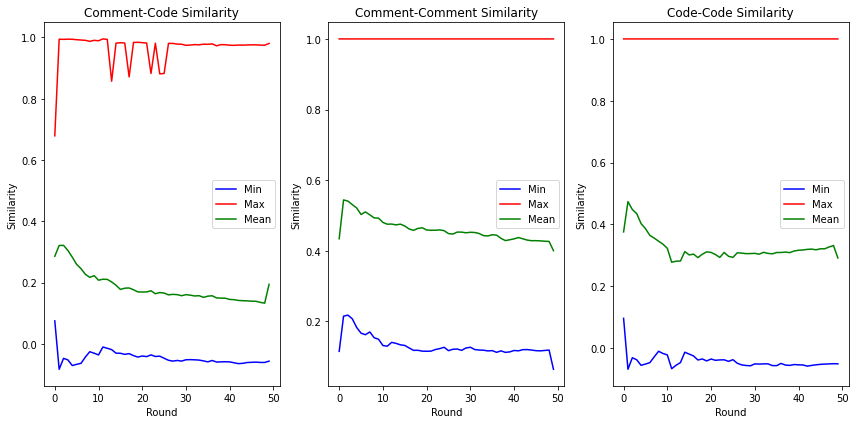

Min/Max values for each round:

Round 0:
Comment-Code Similarity: min=0.0750, max=0.6790
Comment-Comment Similarity: min=0.1150, max=1.0000
Code-Code Similarity: min=0.0957, max=1.0000

Round 1:
Comment-Code Similarity: min=-0.0829, max=0.9944
Comment-Comment Similarity: min=0.2147, max=1.0000
Code-Code Similarity: min=-0.0691, max=1.0000

Round 2:
Comment-Code Similarity: min=-0.0473, max=0.9938
Comment-Comment Similarity: min=0.2176, max=1.0000
Code-Code Similarity: min=-0.0318, max=1.0000

Round 3:
Comment-Code Similarity: min=-0.0523, max=0.9944
Comment-Comment Similarity: min=0.2070, max=1.0000
Code-Code Similarity: min=-0.0384, max=1.0000

Round 4:
Comment-Code Similarity: min=-0.0707, max=0.9941
Comment-Comment Similarity: min=0.1826, max=1.0000
Code-Code Similarity: min=-0.0563, max=1.0000

Round 5:
Comment-Code Similarity: min=-0.0668, max=0.9927
Comment-Comment Similarity: min=0.1664, max=1.0000
Code-Code Similarity: min=-0.0522, max=1.0000

Round 6:
Comment-Code Similarity: 

In [120]:
import matplotlib.pyplot as plt
# Plot min/max/mean metrics for each round
metrics = {
    'inter_comment_code_sim': (all_inter_comment_code_sims, 'Comment-Code Similarity'),
    'intra_comment_sim': (all_intra_comment_sims, 'Comment-Comment Similarity'), 
    'intra_code_sim': (all_intra_code_sims, 'Code-Code Similarity')
}

plt.figure(figsize=(12, 6))
for i, (metric_name, (metric_data, label)) in enumerate(metrics.items()):
    plt.subplot(1, 3, i+1)
    plt.title(label)
    
    # Get min/max/mean for each round (metric_data shape is (3, 6, 37))
    min_vals = np.min(metric_data, axis=(1,2))  # Shape: (3,)
    max_vals = np.max(metric_data, axis=(1,2))  # Shape: (3,)
    mean_vals = np.mean(metric_data, axis=(1,2))  # Shape: (3,)
    
    rounds = range(len(min_vals))
    plt.plot(rounds, min_vals, 'b-', label='Min')
    plt.plot(rounds, max_vals, 'r-', label='Max') 
    plt.plot(rounds, mean_vals, 'g-', label='Mean')
    plt.xlabel('Round')
    plt.ylabel('Similarity')
    plt.legend()

plt.tight_layout()
plt.show()

# Print min/max values for each round
print("Min/Max values for each round:")
for round_idx in range(len(all_inter_comment_code_sims)):
    print(f"\nRound {round_idx}:")
    print(f"Comment-Code Similarity: min={np.min(all_inter_comment_code_sims[round_idx]):.4f}, max={np.max(all_inter_comment_code_sims[round_idx]):.4f}")
    print(f"Comment-Comment Similarity: min={np.min(all_intra_comment_sims[round_idx]):.4f}, max={np.max(all_intra_comment_sims[round_idx]):.4f}")
    print(f"Code-Code Similarity: min={np.min(all_intra_code_sims[round_idx]):.4f}, max={np.max(all_intra_code_sims[round_idx]):.4f}")

In [121]:
all_inter_comment_code_sims[0].shape

(10, 59)

Calculating positive and negative similarities...


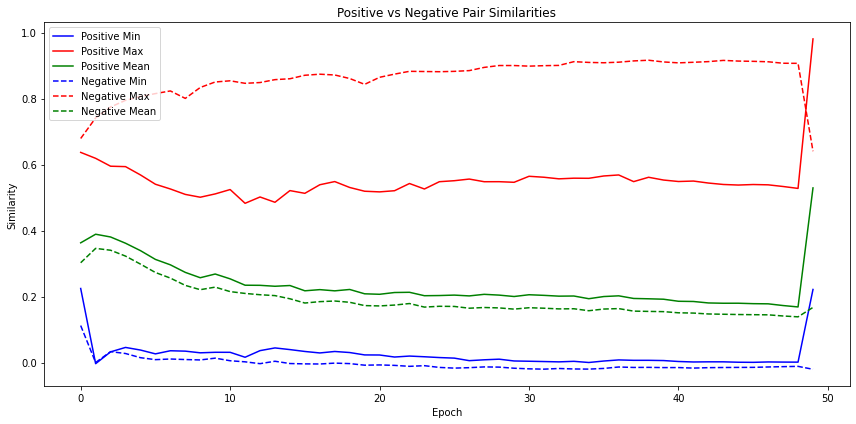


Similarity Statistics by Epoch:

Epoch 0:
Positive pairs:
  Mean: 0.3630
  Max:  0.6369
  Min:  0.2247
Negative pairs:
  Mean: 0.3027
  Max:  0.6790
  Min:  0.1124

Epoch 1:
Positive pairs:
  Mean: 0.3890
  Max:  0.6189
  Min:  -0.0031
Negative pairs:
  Mean: 0.3462
  Max:  0.7413
  Min:  0.0005

Epoch 2:
Positive pairs:
  Mean: 0.3807
  Max:  0.5950
  Min:  0.0328
Negative pairs:
  Mean: 0.3406
  Max:  0.7744
  Min:  0.0335

Epoch 3:
Positive pairs:
  Mean: 0.3618
  Max:  0.5938
  Min:  0.0462
Negative pairs:
  Mean: 0.3228
  Max:  0.7946
  Min:  0.0278

Epoch 4:
Positive pairs:
  Mean: 0.3393
  Max:  0.5686
  Min:  0.0383
Negative pairs:
  Mean: 0.2985
  Max:  0.8061
  Min:  0.0151

Epoch 5:
Positive pairs:
  Mean: 0.3128
  Max:  0.5404
  Min:  0.0267
Negative pairs:
  Mean: 0.2731
  Max:  0.8150
  Min:  0.0092

Epoch 6:
Positive pairs:
  Mean: 0.2964
  Max:  0.5261
  Min:  0.0361
Negative pairs:
  Mean: 0.2562
  Max:  0.8230
  Min:  0.0111

Epoch 7:
Positive pairs:
  Mean: 0.2735
 

In [122]:
# Calculate positive and negative similarities
print("Calculating positive and negative similarities...")

# Add 1 to each value in comment_list and code_list
comment_list_plus_one = [[x + 1 for x in sublist] for sublist in comment_list]
code_list_plus_one = [[x + 1 for x in sublist] for sublist in code_list]


positive_sims = []
negative_sims = []

for epoch_idx, epoch_sims in enumerate(all_inter_comment_code_sims):
    epoch_pos_sims = []
    epoch_neg_sims = []
    
    # Get positive pairs from match_list
    for i in range(len(comment_list_plus_one)):
        for comment_idx in comment_list_plus_one[i]:
            for code_idx in code_list_plus_one[i]:
                if comment_idx < (all_inter_comment_code_sims[0].shape[0] - 1) and code_idx < (all_inter_comment_code_sims[0].shape[1] - 1):
                    pos_sim = epoch_sims[comment_idx][code_idx]
                    epoch_pos_sims.append(pos_sim)
            
                    # Get negative pairs - all code tokens not in this code_list[i]
                    comment_neg_sims = []
                    for other_code_idx in range((all_inter_comment_code_sims[0].shape[1] - 1)):
                        if other_code_idx not in code_list_plus_one[i]:
                            neg_sim = epoch_sims[comment_idx][other_code_idx]
                            comment_neg_sims.append(neg_sim)
                    epoch_neg_sims.extend(comment_neg_sims)
    
    positive_sims.append(epoch_pos_sims)
    negative_sims.append(epoch_neg_sims)

# Plot min/max/mean metrics for positive and negative similarities in one plot
plt.figure(figsize=(12, 6))
plt.title('Positive vs Negative Pair Similarities')

epochs = range(len(positive_sims))

# Plot positive similarities
pos_min_vals = [np.min(pos_sims) for pos_sims in positive_sims]
pos_max_vals = [np.max(pos_sims) for pos_sims in positive_sims]
pos_mean_vals = [np.mean(pos_sims) for pos_sims in positive_sims]

plt.plot(epochs, pos_min_vals, 'b-', label='Positive Min')
plt.plot(epochs, pos_max_vals, 'r-', label='Positive Max')
plt.plot(epochs, pos_mean_vals, 'g-', label='Positive Mean')

# Plot negative similarities
neg_min_vals = [np.min(neg_sims) for neg_sims in negative_sims]
neg_max_vals = [np.max(neg_sims) for neg_sims in negative_sims]
neg_mean_vals = [np.mean(neg_sims) for neg_sims in negative_sims]

plt.plot(epochs, neg_min_vals, 'b--', label='Negative Min')
plt.plot(epochs, neg_max_vals, 'r--', label='Negative Max')
plt.plot(epochs, neg_mean_vals, 'g--', label='Negative Mean')

plt.xlabel('Epoch')
plt.ylabel('Similarity')
plt.legend()
plt.tight_layout()
plt.show()

# Print statistics for each epoch
print("\nSimilarity Statistics by Epoch:")
for epoch in range(len(positive_sims)):
    print(f"\nEpoch {epoch}:")
    
    pos_array = np.array(positive_sims[epoch])
    neg_array = np.array(negative_sims[epoch])
    
    print("Positive pairs:")
    print(f"  Mean: {np.mean(pos_array):.4f}")
    print(f"  Max:  {np.max(pos_array):.4f}")
    print(f"  Min:  {np.min(pos_array):.4f}")
    
    print("Negative pairs:")
    print(f"  Mean: {np.mean(neg_array):.4f}")
    print(f"  Max:  {np.max(neg_array):.4f}")
    print(f"  Min:  {np.min(neg_array):.4f}")


In [125]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import time

# # 读取高维向量 (num, 768)
# input_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/train_data.npy'
# data = np.load(input_path)

ENCODER_DIMS = [768,256,256,256,256,2]
DECODER_DIMS = [2,256,256,256,256,768]

CONTENT_PATH = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp'
EPOCH_START = 50
EPOCH_END = 50
EPOCH_PERIOD = 1
B_N_EPOCHS = 0
N_NEIGHBORS = 5
VIS_MODEL_NAME = 'dvi_aa'
LAMBDA1 = 1
S_N_EPOCHS = 5
PATIENT = 3
MAX_EPOCH = 10
GPU_ID = 3
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")
net = "Model"
CLASSES = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19"]

# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)

# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)

umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)
single_loss_fn = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=1)
# Define Projector
projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)

prev_model = VisModel(ENCODER_DIMS, DECODER_DIMS)
start_flag = 1

for iteration in range(EPOCH_START, EPOCH_END+EPOCH_PERIOD, EPOCH_PERIOD):
    # Define DVI Loss
    if start_flag:
        temporal_loss_fn = DummyTemporalLoss(DEVICE)
        criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=1, lambd2=0.0,device=DEVICE)
        start_flag = 0
    else:
        # TODO AL mode, redefine train_representation
        prev_data = data_provider.train_representation(iteration-EPOCH_PERIOD)
        prev_data = prev_data.reshape(prev_data.shape[0],prev_data.shape[1])
        curr_data = data_provider.train_representation(iteration)
        curr_data = curr_data.reshape(curr_data.shape[0],curr_data.shape[1])
        print(prev_data.shape, curr_data.shape)
        t_1= time.time()
        npr = torch.tensor(find_neighbor_preserving_rate(prev_data, curr_data, N_NEIGHBORS)).to(DEVICE)
        t_2= time.time()
     
        temporal_loss_fn = TemporalLoss(w_prev, DEVICE)
        criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=1, lambd2=0.1*npr,device=DEVICE)

    # Define training parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)
    # Define Edge dataset

    t0 = time.time()
    ##### construct the spitial complex
    spatial_cons = SingleEpochTextSpatialEdgeConstructor(data_provider, iteration, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS, net)
    edge_to, edge_from, probs, feature_vectors, attention = spatial_cons.construct()
    t1 = time.time()

    print('complex-construct:', t1-t0)

    probs = probs / (probs.max()+1e-3)
    eliminate_zeros = probs> 1e-3    #1e-3
    edge_to = edge_to[eliminate_zeros]
    edge_from = edge_from[eliminate_zeros]#     probs = probs[eliminate_zeros]
    
    labels_non_boundary = np.zeros(len(edge_to))

    # pred_list = data_provider.get_pred(iteration, feature_vectors)
    pred_list = np.zeros(feature_vectors.shape)
    dataset = VisDataHandler(edge_to, edge_from, feature_vectors, attention, probs,pred_list)

    n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
    # chose sampler based on the number of dataset
    if len(edge_to) > pow(2,24):
        sampler = CustomWeightedRandomSampler(probs, n_samples, replacement=True)
    else:
        sampler = WeightedRandomSampler(probs, n_samples, replacement=True)
    edge_loader = DataLoader(dataset, batch_size=2000, sampler=sampler, num_workers=8, prefetch_factor=10)

    ########################################################################################################################
    #                                                       TRAIN                                                          #
    ########################################################################################################################

    trainer = BaseTextTrainer(model, criterion, optimizer, lr_scheduler, edge_loader=edge_loader, DEVICE=DEVICE)

    t2=time.time()
    trainer.train(PATIENT, MAX_EPOCH, data_provider,iteration)
    t3 = time.time()
    print('training:', t3-t2)
    # save result
    save_dir = data_provider.model_path
    trainer.record_time(save_dir, "time_{}".format(VIS_MODEL_NAME), "complex_construction", str(iteration), t1-t0)
    trainer.record_time(save_dir, "time_{}".format(VIS_MODEL_NAME), "training", str(iteration), t3-t2)
    save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(iteration))
    trainer.save(save_dir=save_dir, file_name="{}".format(VIS_MODEL_NAME))

    print("Finish epoch {}...".format(iteration))
 
    prev_model.load_state_dict(model.state_dict())
    for param in prev_model.parameters():
        param.requires_grad = False
    w_prev = dict(prev_model.named_parameters())


Finish initialization...
Fri Jan 17 10:27:15 2025 Building RP forest with 5 trees
Fri Jan 17 10:27:16 2025 NN descent for 6 iterations
	 1  /  6
	 2  /  6
	Stopping threshold met -- exiting after 2 iterations
complex-construct: 0.3785238265991211
epoch:1


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


umap:6.4818	recon_l:0.3341	new_loss:6.4818	loss:6.8159
epoch:2


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


umap:0.9829	recon_l:0.3721	new_loss:0.9829	loss:1.3550
epoch:3


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


umap:0.4339	recon_l:0.3318	new_loss:0.4339	loss:0.7657
epoch:4


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


umap:0.5582	recon_l:0.8096	new_loss:0.5582	loss:1.3678
epoch:5


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


umap:0.6242	recon_l:0.7595	new_loss:0.6242	loss:1.3837
epoch:6


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


umap:0.5667	recon_l:0.4695	new_loss:0.5667	loss:1.0362
epoch:7


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


umap:0.5778	recon_l:0.3366	new_loss:0.5778	loss:0.9143
epoch:8


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


umap:0.5522	recon_l:0.3189	new_loss:0.5522	loss:0.8711
epoch:9


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


umap:0.5028	recon_l:0.3135	new_loss:0.5028	loss:0.8163
epoch:10


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

umap:0.5405	recon_l:0.3129	new_loss:0.5405	loss:0.8534
Time spend: 22.17 for training vis model...
training: 22.167245149612427
Successfully save visualization model...
Finish epoch 50...


Successfully load the DVI visualization model for iteration 50
x_min: -54.65740165710449, x_max: 39.16097602844238, y_min: -39.763885498046875, y_max: 10.86553966999054


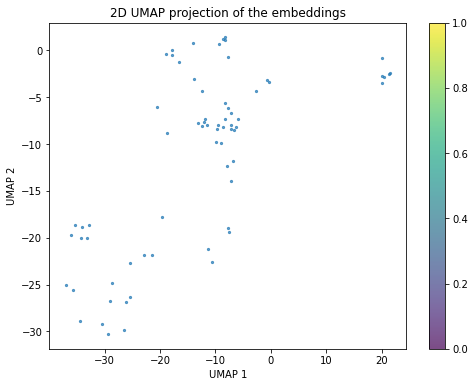

Scale saved to /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_50/scale.npy
Embedding saved to /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_50/embedding.npy


In [126]:
import matplotlib.pyplot as plt
for iteration in range(EPOCH_START, EPOCH_END+EPOCH_PERIOD, EPOCH_PERIOD):
    iter_data = data_provider.train_representation(iteration)
    embedding = projector.batch_project(iteration, iter_data)
    all_nodes_2d = embedding  # 使用你降维后的二维数据

    x_min, y_min = np.min(all_nodes_2d, axis=0)
    x_max, y_max = np.max(all_nodes_2d, axis=0)
    # ebd_extent = ebd_max - ebd_min
    x_extent = x_max - x_min
    y_extent = y_max - y_min

    x_min = x_min - 0.3 * x_extent
    x_max = x_max + 0.3 * x_extent
    y_min = y_min - 0.3 * y_extent
    y_max = y_max + 0.3 * y_extent

    # 打印结果
    print(f"x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}")

    # 将结果保存到指定文件夹
    save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(iteration))
    scale_path = os.path.join(save_dir, "scale.npy")
    np.save(scale_path, [x_min, y_min, x_max, y_max])

    # 保存embedding结果
    embedding_path = os.path.join(save_dir, "embedding.npy") 
    np.save(embedding_path, embedding)

    # 可视化 embedding 的二维散点图
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral', alpha=0.7)
    plt.title('2D UMAP projection of the embeddings')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar()
    plt.show()

    print(f"Scale saved to {scale_path}")
    print(f"Embedding saved to {embedding_path}")
